## **1. Introduction to The Dataset:**

The whole data divided to train and test . Target isn't included in test but the test target values data file is in hands for related tasks. A sample submission correspond to enrollee_id of test set provided too with columns : enrollee_id , target.

**Note:**
* The dataset is imbalanced.
* Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
* Missing imputation can be a part of your pipeline as well.

**Features**
* enrollee_id : Unique ID for candidate
* city: City code
* city_ development_index : Developement index of the city (scaled) 
* gender: Gender of candidate
* relevent_experience: Relevant experience of candidate
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate
* major_discipline :Education major discipline of candidate
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* last_new_job: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


## **Loading essential libraries**

In [2]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import warnings

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

## **2. Working with The Training Dataset:**

In [3]:
train_data= pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
train_data.tail()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0
19157,23834,city_67,0.855,NaN,No relevent experience,no_enrollment,Primary School,NaN,2,NaN,NaN,1,127,0.0


In [5]:
train_data.shape

(19158, 14)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

#### The training dataset has some null values.

In [7]:
train_data.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [8]:
train_data.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [9]:
train_data.isnull().mean()

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [10]:
train_data.drop(['enrollee_id', 'city'], axis=1, inplace=True)
train_data

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


#### All null values have been dropped and saved in clean_train_data. 

In [11]:
clean_train_data=train_data.dropna(inplace=False)
clean_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8955 entries, 1 to 19155
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  8955 non-null   float64
 1   gender                  8955 non-null   object 
 2   relevent_experience     8955 non-null   object 
 3   enrolled_university     8955 non-null   object 
 4   education_level         8955 non-null   object 
 5   major_discipline        8955 non-null   object 
 6   experience              8955 non-null   object 
 7   company_size            8955 non-null   object 
 8   company_type            8955 non-null   object 
 9   last_new_job            8955 non-null   object 
 10  training_hours          8955 non-null   int64  
 11  target                  8955 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 909.5+ KB


## **3. Data Visualization:**
#### Initially, the data visualization is done on the cleaned dataset after removing all null values.

### 3.1 City development index

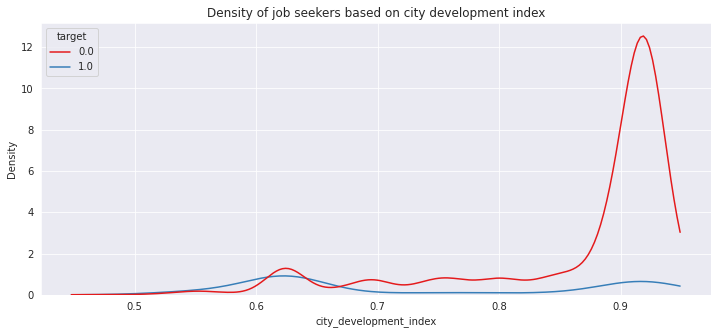

In [12]:
plt.figure(figsize=(12, 5))
g1=sns.kdeplot(data=clean_train_data, x="city_development_index", hue="target",cut = 0,palette='Set1')
g1.set_title('Density of job seekers based on city development index')
plt.show()

### 3.2 Training hours

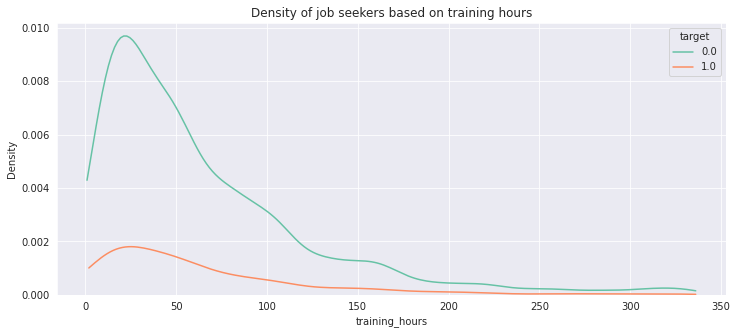

In [13]:
plt.figure(figsize=(12, 5))
g2=sns.kdeplot(data=clean_train_data, x="training_hours", hue="target",cut = 0,palette='Set2')
g2.set_title('Density of job seekers based on training hours')
plt.show()

### 3.3 Gender

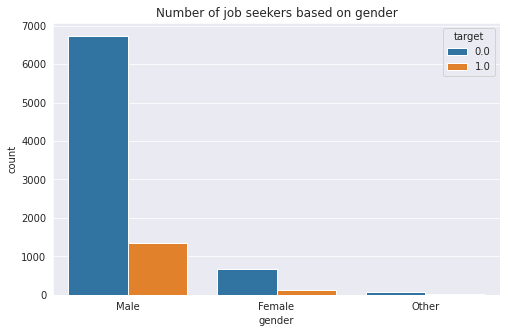

In [14]:
plt.figure(figsize=(8, 5))
g3=sns.countplot(x = 'gender',hue='target',data=clean_train_data)
g3.set_title('Number of job seekers based on gender')
plt.show()

### 3.4 Relevant experience

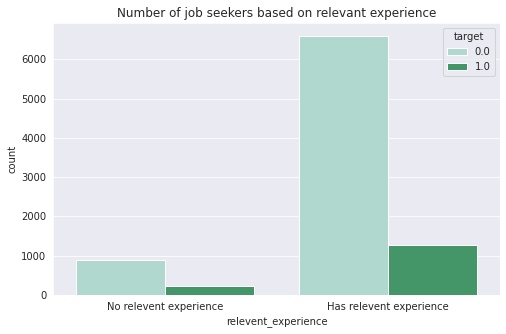

In [15]:
plt.figure(figsize=(8, 5))
g4=sns.countplot(x = 'relevent_experience',hue='target',data=clean_train_data,palette='BuGn')
g4.set_title('Number of job seekers based on relevant experience')
plt.show()

### 3.5 Enrolled university

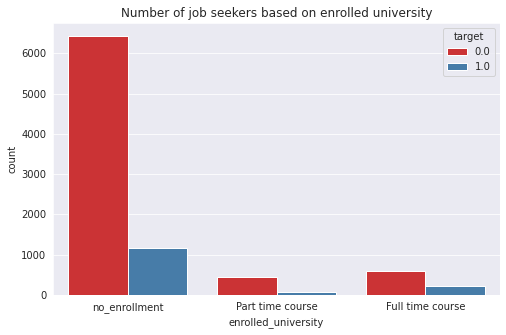

In [16]:
plt.figure(figsize=(8, 5))
g5=sns.countplot(x = 'enrolled_university',hue='target',data=clean_train_data,palette='Set1')
g5.set_title('Number of job seekers based on enrolled university')
plt.show()

### 3.6 Education level

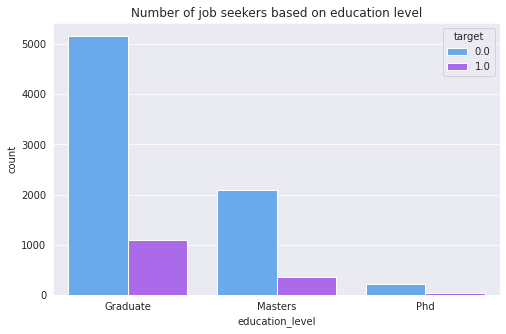

In [17]:
plt.figure(figsize=(8, 5))
g6=sns.countplot(x = 'education_level',hue='target',data=clean_train_data,palette='cool')
g6.set_title('Number of job seekers based on education level')
plt.show()

### 3.7 Major discipline

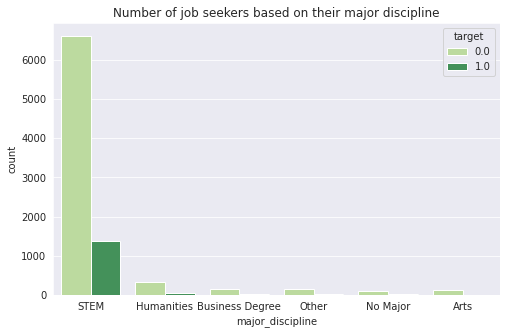

In [18]:
plt.figure(figsize=(8, 5))
g7=sns.countplot(x = 'major_discipline',hue='target',data=clean_train_data,palette='YlGn')
g7.set_title('Number of job seekers based on their major discipline')
plt.show()

#### Data is sorted for plotting bar-graph of 'experience' column.

In [19]:
clean_train_data["experience"].fillna("20", inplace = True)

clean_train_data.replace({"experience":{">20":20,"<1":1}},inplace = True)

clean_train_data["experience"] = clean_train_data["experience"].astype("int64")

### 3.8 Total experience

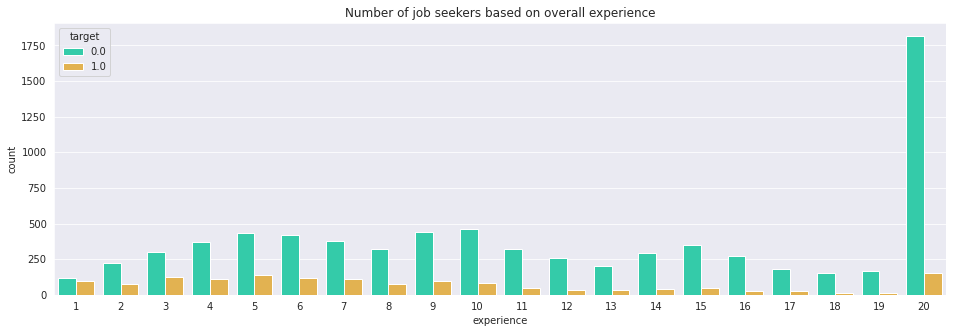

In [20]:
plt.figure(figsize=(16, 5))
g8=sns.countplot(x = 'experience',hue="target",data=clean_train_data,palette='turbo')
g8.set_title('Number of job seekers based on overall experience')
plt.show()

### 3.9 Company size

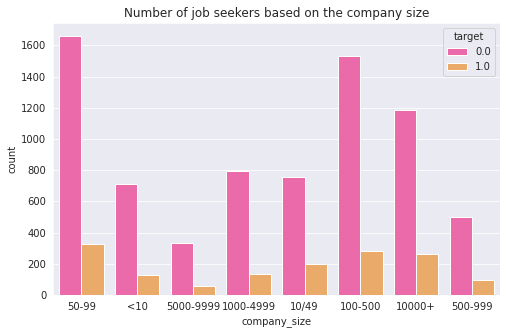

In [21]:
plt.figure(figsize=(8, 5))
g9=sns.countplot(x = 'company_size',hue='target',data=clean_train_data,palette='spring')
g9.set_title('Number of job seekers based on the company size')
plt.show()

### 3.10 Company type

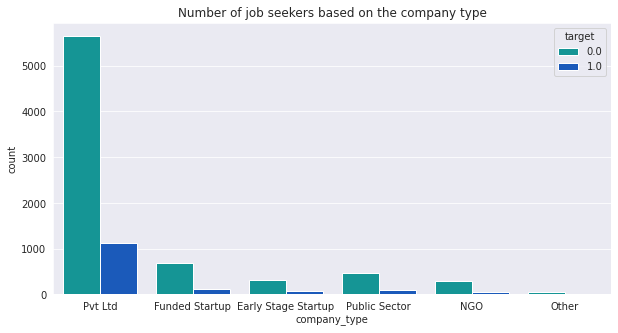

In [22]:
plt.figure(figsize=(10, 5))
g10=sns.countplot(x = 'company_type',hue='target',data=clean_train_data,palette='winter_r')
g10.set_title('Number of job seekers based on the company type')
plt.show()

### 3.11 Last_new_job

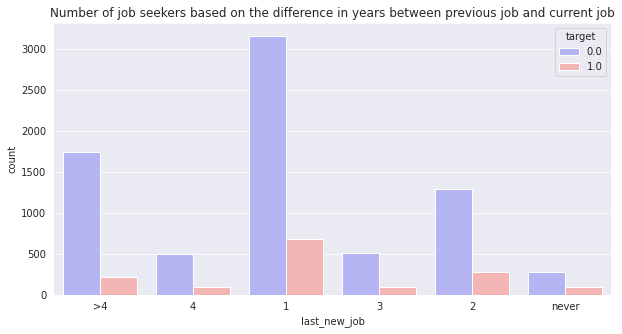

In [23]:
plt.figure(figsize=(10, 5))
g11=sns.countplot(x = 'last_new_job',hue='target',data=clean_train_data,palette='bwr')
g11.set_title('Number of job seekers based on the difference in years between previous job and current job')
plt.show()

### 3.12 Relevent experience vs Training hours

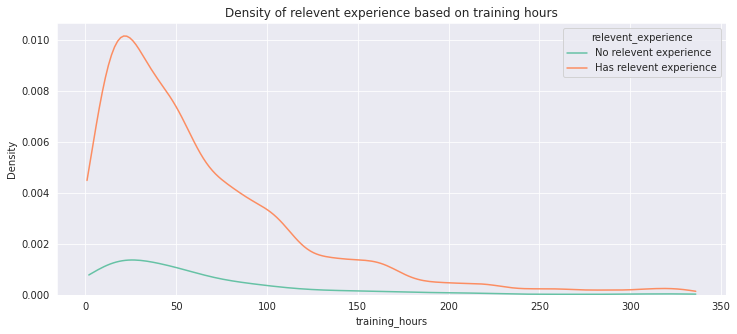

In [24]:
plt.figure(figsize=(12, 5))
g12=sns.kdeplot(data=clean_train_data, x="training_hours", hue="relevent_experience",cut = 0,palette='Set2')
g12.set_title('Density of relevent experience based on training hours')
plt.show()

### 3.13 Relevent experience vs Education level

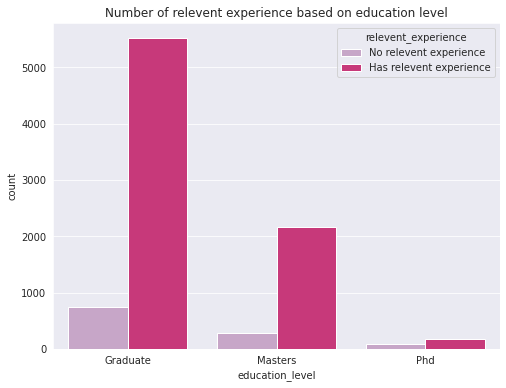

In [25]:
plt.figure(figsize=(8, 6))
g13=sns.countplot(x = 'education_level',hue='relevent_experience',data=clean_train_data,palette='PuRd')
g13.set_title('Number of relevent experience based on education level')
plt.show()

## **4. Data Preprocessing:**
#### Preprocessing of data has been done on train_data, without dropping the null values.

#### The columns have been divided into numerical and categorical for future analysis.

In [26]:
num_cols= ['city_development_index' ,'training_hours']
cat_cols= train_data.drop(['city_development_index' ,'training_hours', 'target'], axis=1).columns

In [27]:
cat_cols

Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')

### 4.1 Exploratory Data Analysis

In [28]:
train_data.profile_report()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
train_data['company_size']= train_data['company_size'].replace('10/49', '10-49')

In [30]:
exp_counts= train_data['experience'].value_counts()
exp_counts

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

In [31]:
train_data.head(5)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [32]:
print (train_data.dtypes)

city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object


### 4.2 Encoding Categorical Variables

In [33]:
le= LabelEncoder()

for col in cat_cols:
    train_data[col] = le.fit_transform(train_data[col].astype(str))

In [34]:
train_data

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,1,0,3,0,5,21,8,6,0,36,1.0
1,0.776,1,1,3,0,5,6,4,5,4,47,0.0
2,0.624,3,1,0,0,5,15,8,6,6,83,0.0
3,0.789,3,1,2,0,1,20,8,5,6,52,1.0
4,0.767,1,0,3,2,5,21,4,1,3,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,1,1,3,0,2,5,8,6,0,42,1.0
19154,0.920,1,0,3,0,5,5,8,6,3,52,1.0
19155,0.920,1,0,3,0,5,21,4,5,3,44,0.0
19156,0.802,1,0,3,1,6,20,5,5,1,97,0.0


### 4.3 Dealing with Missing Values

In [35]:
lr= LinearRegression()

imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'roman')
train_data_final = imputer.fit_transform(train_data.drop('target', axis=1))

train_data_final = pd.DataFrame(train_data_final, columns = train_data.drop('target', axis=1).columns)

In [36]:
train_data_final.isnull().sum()

city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [37]:
train_data_final.sample(5)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
8805,0.926,3.0,0.0,3.0,0.0,5.0,21.0,0.0,5.0,4.0,62.0
7551,0.920,1.0,0.0,3.0,0.0,5.0,2.0,4.0,5.0,4.0,290.0
10098,0.920,1.0,0.0,3.0,0.0,5.0,21.0,2.0,5.0,3.0,69.0
3083,0.939,1.0,0.0,3.0,0.0,5.0,5.0,1.0,5.0,4.0,39.0
14765,0.550,3.0,0.0,3.0,0.0,5.0,13.0,0.0,5.0,0.0,102.0


In [38]:
train_data['target']= train_data['target'].map(lambda x: 1 if x==1.0 else 0)

### 4.4 Correlation Matrix

<AxesSubplot:>

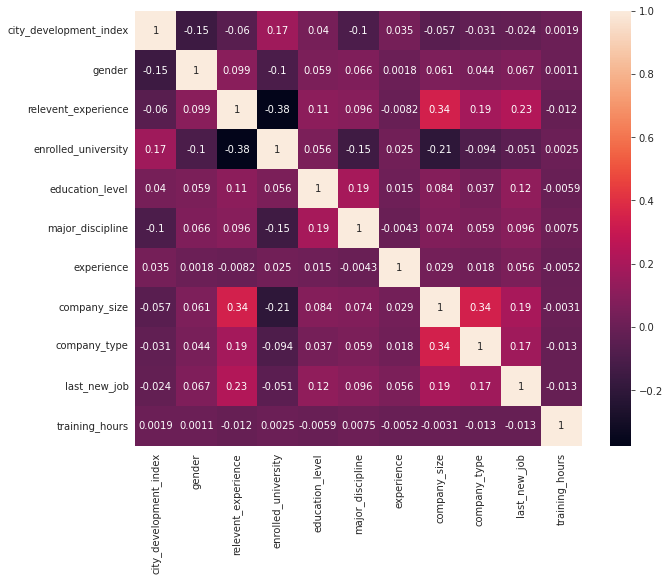

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data_final.corr(), annot=True)

In [40]:
cor = train_data_final.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

gender               city_development_index   -0.154868
enrolled_university  city_development_index    0.171612
                     gender                   -0.104901
                     relevent_experience      -0.375810
education_level      relevent_experience       0.111214
major_discipline     city_development_index   -0.101260
                     enrolled_university      -0.146363
                     education_level           0.190048
company_size         relevent_experience       0.343754
                     enrolled_university      -0.208255
company_type         relevent_experience       0.188282
                     company_size              0.341661
last_new_job         relevent_experience       0.228555
                     education_level           0.121864
                     company_size              0.194668
                     company_type              0.171732
dtype: float64

### 4.5 Checking The Data after Preprocessing

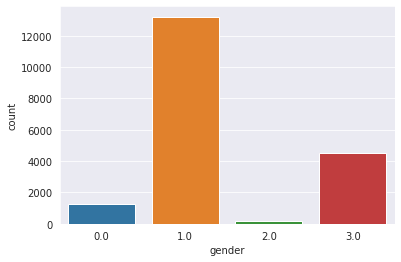

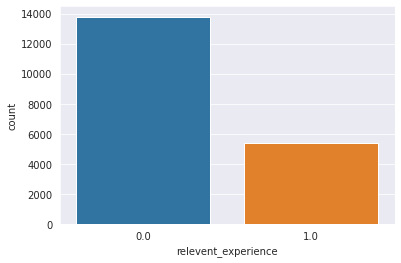

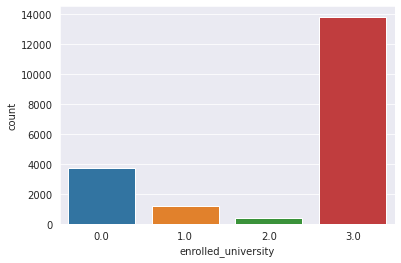

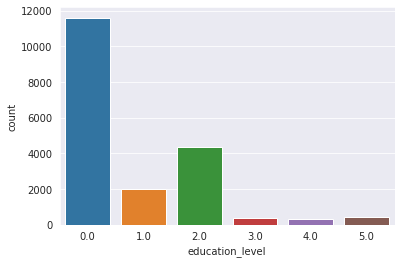

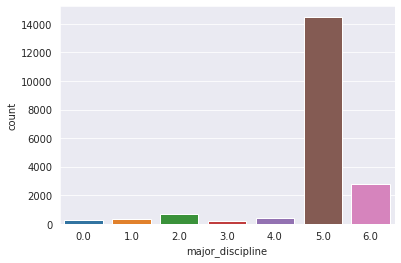

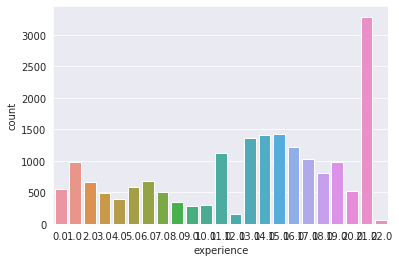

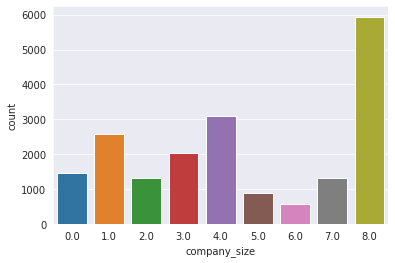

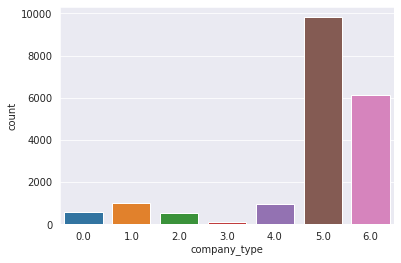

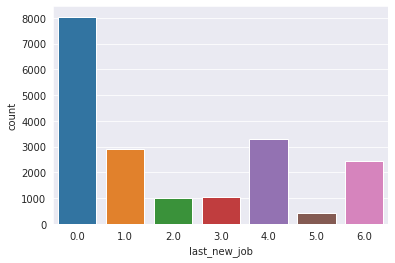

In [41]:
for col in cat_cols:
    plt.figure()
    sns.countplot(train_data_final[col])
        
        
plt.show()

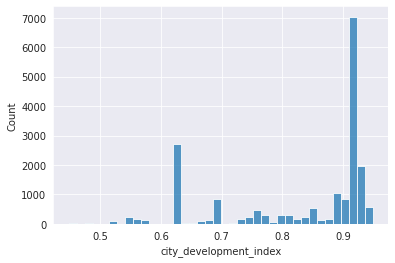

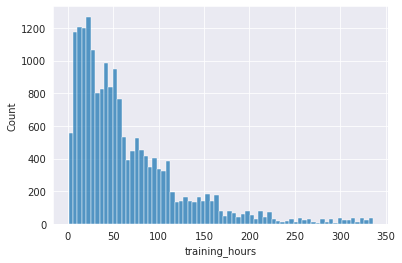

In [42]:
for col in num_cols:
    plt.figure()
    sns.histplot(train_data_final[col])
    
plt.show()

### 4.6 Splitting The Data

In [43]:
X= train_data_final
y= train_data['target']
X_train, X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, stratify=y,random_state=42)

In [44]:
X_train

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
17855,0.624,3.0,0.0,3.0,0.0,5.0,1.0,4.0,5.0,0.0,90.0
17664,0.920,1.0,1.0,3.0,4.0,6.0,15.0,8.0,6.0,6.0,15.0
13404,0.896,1.0,0.0,3.0,0.0,5.0,3.0,2.0,2.0,4.0,36.0
13366,0.920,1.0,0.0,3.0,0.0,5.0,15.0,1.0,1.0,0.0,53.0
15670,0.855,0.0,0.0,0.0,0.0,5.0,15.0,8.0,6.0,0.0,158.0
...,...,...,...,...,...,...,...,...,...,...,...
10398,0.855,3.0,0.0,3.0,0.0,5.0,4.0,4.0,5.0,0.0,94.0
859,0.920,0.0,0.0,3.0,2.0,5.0,1.0,4.0,5.0,0.0,16.0
10566,0.893,0.0,0.0,3.0,2.0,5.0,5.0,1.0,5.0,0.0,34.0
3085,0.624,0.0,0.0,3.0,0.0,5.0,6.0,0.0,1.0,1.0,112.0


In [45]:
y_train

17855    0
17664    0
13404    0
13366    0
15670    1
        ..
10398    0
859      0
10566    0
3085     0
3019     1
Name: target, Length: 15326, dtype: int64

### 4.7 Standardizing Numerical Columns

In [46]:
ss= StandardScaler()
X_train[num_cols]= ss.fit_transform(X_train[num_cols])
X_test[num_cols]= ss.transform(X_test[num_cols])

In [47]:
X_train

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
17855,-1.672102,3.0,0.0,3.0,0.0,5.0,1.0,4.0,5.0,0.0,0.411648
17664,0.734358,1.0,1.0,3.0,4.0,6.0,15.0,8.0,6.0,6.0,-0.839076
13404,0.539240,1.0,0.0,3.0,0.0,5.0,3.0,2.0,2.0,4.0,-0.488873
13366,0.734358,1.0,0.0,3.0,0.0,5.0,15.0,1.0,1.0,0.0,-0.205376
15670,0.205913,0.0,0.0,0.0,0.0,5.0,15.0,8.0,6.0,0.0,1.545638
...,...,...,...,...,...,...,...,...,...,...,...
10398,0.205913,3.0,0.0,3.0,0.0,5.0,4.0,4.0,5.0,0.0,0.478353
859,0.734358,0.0,0.0,3.0,2.0,5.0,1.0,4.0,5.0,0.0,-0.822400
10566,0.514850,0.0,0.0,3.0,2.0,5.0,5.0,1.0,5.0,0.0,-0.522226
3085,-1.672102,0.0,0.0,3.0,0.0,5.0,6.0,0.0,1.0,1.0,0.778527


## **5. Training The Data:**

In [48]:
key= ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'DecisionTreeRegressor', 'GaussianNB',  
      'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier', 'KNeighborsClassifier',  'SVC']

value= [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), DecisionTreeRegressor(), GaussianNB(),
        XGBClassifier(), LGBMClassifier(), CatBoostClassifier(verbose=False), KNeighborsClassifier(), SVC()]
models= dict(zip(key, value))

In [49]:
models

{'LogisticRegression': LogisticRegression(),
 'RandomForestClassifier': RandomForestClassifier(),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'GaussianNB': GaussianNB(),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'LGBMClassifier': LGBMClassifier(),
 'CatBoostClassifier': <catboost.core.CatBoostClassifier at 0x7fb19d40d7d

In [50]:
scores=[]
for key,value in models.items():
    score= -1*cross_val_score(value, X,y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)
    print(key, score.mean())

LogisticRegression nan
RandomForestClassifier 0.21881209984038574
DecisionTreeClassifier 0.2847378871081917
DecisionTreeRegressor 0.28575540080946066
GaussianNB 0.24511963985702834
[05:24:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:24:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:24:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:24:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost

In [51]:
accuracy_scores=[]
for key,value in models.items():
    value.fit(X_train,y_train)
    y_pred= value.predict(X_test)
    accuracy= value.score(X_test,y_test)
    
    accuracy_scores.append(accuracy)
    print(key, accuracy)

LogisticRegression 0.7750521920668059
RandomForestClassifier 0.7766179540709812
DecisionTreeClassifier 0.7111169102296451
DecisionTreeRegressor -0.5338265026651159
GaussianNB 0.7596555323590815
[05:26:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.7922755741127349
LGBMClassifier 0.7993215031315241
CatBoostClassifier 0.7972338204592901
KNeighborsClassifier 0.7617432150313153
SVC 0.7510438413361169


#### From the mean scores and accuracy scores, it can be seen that CatBoostClassifier and LGBMClassifier are the best models.

In [52]:
ctb= CatBoostClassifier(random_state=42)
ctb.fit(X_train,y_train,verbose=False)
y_pred= ctb.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2514  363]
 [ 417  538]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2877
           1       0.60      0.56      0.58       955

    accuracy                           0.80      3832
   macro avg       0.73      0.72      0.72      3832
weighted avg       0.79      0.80      0.79      3832



In [53]:
lgbm= LGBMClassifier(random_state=42)
lgbm.fit(X_train,y_train)
y_pred= lgbm.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2467  410]
 [ 359  596]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2877
           1       0.59      0.62      0.61       955

    accuracy                           0.80      3832
   macro avg       0.73      0.74      0.74      3832
weighted avg       0.80      0.80      0.80      3832



#### After comparing the confusion matrices, it can be said that the LGBMClassifier is the best model.

### 5.1 LightGBM Feature Importance

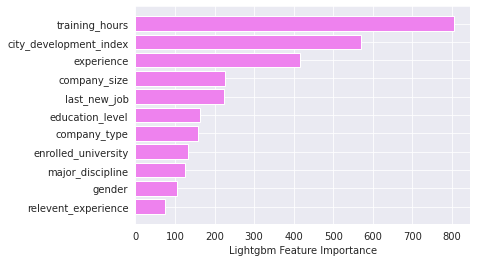

In [54]:
sorted_idx = lgbm.feature_importances_.argsort()
plt.barh(train_data_final.columns[sorted_idx], lgbm.feature_importances_[sorted_idx],color = 'violet')
plt.xlabel("Lightgbm Feature Importance")
plt.show()

## **6. Tuning The Hyperparameters:**

In [55]:
lgbm_params = {
 'colsample_bytree': [0.6,0.8,1.0],
 'learning_rate': [0.033,0.057,0.1],
 'max_depth': [3,4,5,6],
 'min_child_weight': [1,5,10,12],
 'n_estimators': [150,300,450,600],
 'num_leaves': [10,20,30],
 'subsample': [0.6,0.8,1.0]
 }

lgbm= LGBMClassifier(**lgbm_params)

lgbm

LGBMClassifier(colsample_bytree=[0.6, 0.8, 1.0],
               learning_rate=[0.033, 0.057, 0.1], max_depth=[3, 4, 5, 6],
               min_child_weight=[1, 5, 10, 12],
               n_estimators=[150, 300, 450, 600], num_leaves=[10, 20, 30],
               subsample=[0.6, 0.8, 1.0])

In [56]:
tuned_lgbm= RandomizedSearchCV(lgbm, param_distributions=lgbm_params, cv = 5, n_iter=5, verbose=2)

tuned_lgbm.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8, total=   0.4s
[CV] subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8, total=   0.4s
[CV] subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8 
[CV]  subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8, total=   0.4s
[CV] subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8 
[CV]  subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8, total=   0.4s
[CV] subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8 
[CV]  subsample=0.6, num_leaves=30, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.057, colsample_bytree=0.8, total=   0.4s
[CV] subsample=0.8, num_leaves

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.1s finished


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(colsample_bytree=[0.6, 0.8, 1.0],
                                            learning_rate=[0.033, 0.057, 0.1],
                                            max_depth=[3, 4, 5, 6],
                                            min_child_weight=[1, 5, 10, 12],
                                            n_estimators=[150, 300, 450, 600],
                                            num_leaves=[10, 20, 30],
                                            subsample=[0.6, 0.8, 1.0]),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.033, 0.057, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 5, 10, 12],
                                        'n_estimators': [150, 300, 450, 600],
                                        'num_lea

In [57]:
tuned_lgbm.best_score_

0.7966380189302846

In [58]:
tuned_lgbm.best_estimator_

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.057, max_depth=5,
               min_child_weight=1, n_estimators=150, num_leaves=30)

In [59]:
tuned_lgbm.best_estimator_.fit(X_train,y_train)
y_pred= tuned_lgbm.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2487  390]
 [ 372  583]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2877
           1       0.60      0.61      0.60       955

    accuracy                           0.80      3832
   macro avg       0.73      0.74      0.74      3832
weighted avg       0.80      0.80      0.80      3832



### 6.1 Confusion Matrix

[[2487  390]
 [ 372  583]]


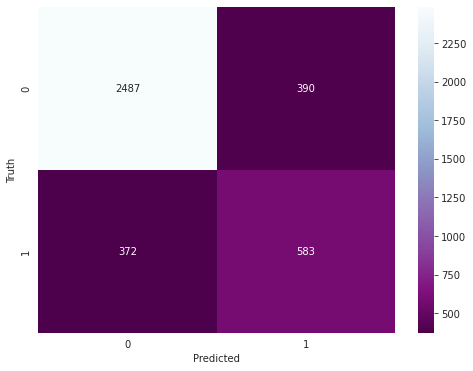

In [60]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, cmap = 'BuPu_r', fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### 6.2 ROC Curve

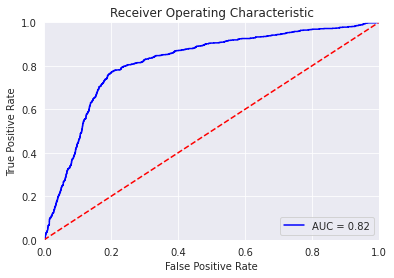

In [61]:
probs = tuned_lgbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **7. Working with The Test Dataset:**

In [62]:
test_data= pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
test_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [63]:
test_data.drop(['enrollee_id', 'city'], axis=1, inplace=True)
test_data

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [64]:
test_data.shape

(2129, 11)

In [65]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  2129 non-null   float64
 1   gender                  1621 non-null   object 
 2   relevent_experience     2129 non-null   object 
 3   enrolled_university     2098 non-null   object 
 4   education_level         2077 non-null   object 
 5   major_discipline        1817 non-null   object 
 6   experience              2124 non-null   object 
 7   company_size            1507 non-null   object 
 8   company_type            1495 non-null   object 
 9   last_new_job            2089 non-null   object 
 10  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 183.1+ KB


In [66]:
test_data.isnull().sum()

city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [67]:
test_data.isnull().mean()

city_development_index    0.000000
gender                    0.238610
relevent_experience       0.000000
enrolled_university       0.014561
education_level           0.024425
major_discipline          0.146548
experience                0.002349
company_size              0.292156
company_type              0.297792
last_new_job              0.018788
training_hours            0.000000
dtype: float64

In [68]:
test_data.describe()

,city_development_index,training_hours
count,2129.000000,2129.000000
mean,0.824984,64.983091
std,0.125074,60.238660
min,0.448000,1.000000
25%,0.698000,23.000000
50%,0.903000,47.000000
75%,0.920000,86.000000
max,0.949000,334.000000


### 7.1 Encoding Categorical Variables

In [69]:
for col in cat_cols:
    test_data[col] = le.fit_transform(test_data[col].astype(str))
    
test_data

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.827,1,0,0,0,5,19,7,6,0,21
1,0.920,0,0,3,0,5,15,8,5,0,98
2,0.624,1,1,3,1,6,20,8,5,6,15
3,0.827,1,0,3,2,5,2,0,5,0,39
4,0.920,1,0,3,0,5,21,3,5,4,72
...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,1,1,3,0,2,7,8,4,3,15
2125,0.897,1,0,3,2,5,9,8,6,1,30
2126,0.887,1,1,3,4,6,13,8,5,6,18
2127,0.804,1,0,0,1,6,17,1,4,0,84


### 7.2 Dealing with Missing Values

In [70]:
test_data_final = imputer.transform(test_data)

test_data_final = pd.DataFrame(test_data_final, columns = test_data.columns)

### 7.3 Standardizing Numerical Columns

In [71]:
test_data_final[num_cols]= ss.transform(test_data_final[num_cols])

In [72]:
test_data_final

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,-0.021725,1.0,0.0,0.0,0.0,5.0,19.0,7.0,6.0,0.0,-0.739018
1,0.734358,0.0,0.0,3.0,0.0,5.0,15.0,8.0,5.0,0.0,0.545059
2,-1.672102,1.0,1.0,3.0,1.0,6.0,20.0,8.0,5.0,6.0,-0.839076
3,-0.021725,1.0,0.0,3.0,2.0,5.0,2.0,0.0,5.0,0.0,-0.438844
4,0.734358,1.0,0.0,3.0,0.0,5.0,21.0,3.0,5.0,4.0,0.111474
...,...,...,...,...,...,...,...,...,...,...,...
2124,0.734358,1.0,1.0,3.0,0.0,2.0,7.0,8.0,4.0,3.0,-0.839076
2125,0.547370,1.0,0.0,3.0,2.0,5.0,9.0,8.0,6.0,1.0,-0.588931
2126,0.466071,1.0,1.0,3.0,4.0,6.0,13.0,8.0,5.0,6.0,-0.789047
2127,-0.208714,1.0,0.0,0.0,1.0,6.0,17.0,1.0,4.0,0.0,0.311590


In [73]:
test_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  2129 non-null   float64
 1   gender                  2129 non-null   float64
 2   relevent_experience     2129 non-null   float64
 3   enrolled_university     2129 non-null   float64
 4   education_level         2129 non-null   float64
 5   major_discipline        2129 non-null   float64
 6   experience              2129 non-null   float64
 7   company_size            2129 non-null   float64
 8   company_type            2129 non-null   float64
 9   last_new_job            2129 non-null   float64
 10  training_hours          2129 non-null   float64
dtypes: float64(11)
memory usage: 183.1 KB


## **8. Running The Best Model on The Test Dataset:**

In [74]:
predictions= tuned_lgbm.best_estimator_.predict(test_data_final)

### 8.1 Final Predictions

In [75]:
my_array = predictions
print(my_array)
np. set_printoptions(threshold=np. inf)
print(my_array)

[0 0 0 ... 0 0 0]
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1
 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1
 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1
 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0
 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 1 0 